<a href="https://colab.research.google.com/github/JontySinai/ProbabilisticProgramming/blob/master/my_BayesianMethodsForHackers/4_RedditUpVotes.ipynb">
  <img style="float: left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Bayesian Methods for Hackers
## Reddit Upvote Distributions
**Chapter 04 - The Law Of Large Numbers**<br>

**Source:** https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/Chapter4_TheGreatestTheoremNeverTold

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip3 install -q wget -q
    import wget

In [2]:
import os
import typing

from typing import Dict, List, Tuple

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy as np
import pandas as pd
import scipy.stats as stats

import pymc3 as pm
import theano.tensor as tt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

np.random.seed(1901)

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from '/home/josinai/anaconda3/envs/axiom/lib/python3.7/site-packages/tensorflow/_api/v2/config/__init__.py'>

# The Law of Large Numbers

Recall the _Law of Large Numbers_ :

$$\text{Let } Z \text{ be a random variable with distribution } \mathscr{P} \text{, then provided that } \mathbb{E}_{\mathscr{P}}[Z] < \infty \text{, the following holds:}
\\
\frac{1}{N} \sum_{i=1}^N Z_i \rightarrow \mathbb{E}[ Z ],  \;\;\; N \rightarrow \infty.
$$

When we are computing a Monte Carlo Estimate, we are relying on the Law of Large Numbers to guarantee that, given enough samples, we can estimate the expected value of the unknown random variable.

We can a simple illustration of this below:

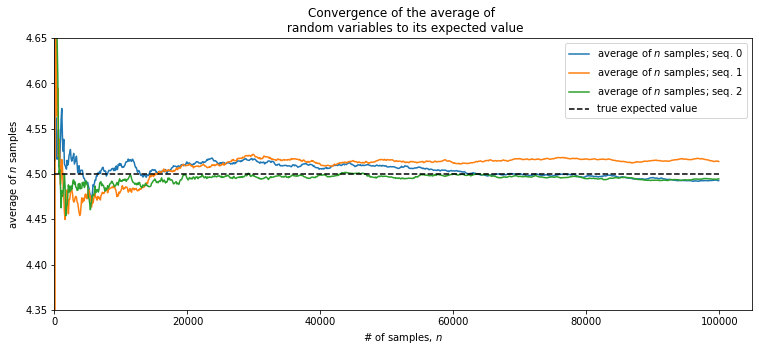

In [3]:
sample_size = 100000
callback_steps = range(1, sample_size, 100)

expected_value = lambda_ = 4.5

figsize(12.5, 5)

# we'll plot three random walks
for k in range(3):
    samples = np.random.poisson(lambda_, sample_size)
    
    moving_average = [samples[:i].mean() for i in callback_steps]
    
    plt.plot(callback_steps, 
             moving_average,
             label="average of $n$ samples; seq. %d" % k,
             lw=1.5)
    
plt.plot(callback_steps,
         expected_value * np.ones_like(moving_average),
         label="true expected value",
         ls='--',
         c='black')

plt.ylim(4.35, 4.65)
plt.xlim(left=0)
plt.title( "Convergence of the average of \n random variables to its \
expected value" )
plt.ylabel( "average of $n$ samples" )
plt.xlabel( "# of samples, $n$")
plt.legend();

#### Convergence Distance Metric

Another way of diagnosing convergence is to compute the distance from the emperical expected value with the true expected value, $\bar{Z}$. This is known as a convergence distance metric. In the case of the moving average, we can calculate the distance with respect to the number of sample steps:

$$D(N) = \sqrt{ \;\mathbb{E}\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - \bar{Z} \;\right)^2 \;\;\right] \;\;}$$

We can approximate the expectation in the formula as follows:

$$ Y_k = \left( \;\frac{1}{N}\sum_{i=1}^NZ_i  - \bar{Z} \; \right)^2 $$

Then taking the average of $N_y$ samples, we have:

$$ \frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k \rightarrow \mathbb{E}[ Y_k ] = \mathbb{E}\;\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - \bar{Z} \;\right)^2 \right] \text{ as } N_Y \rightarrow \infty$$

Then:

$$ \sqrt{\frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k} \approx D(N). $$ 

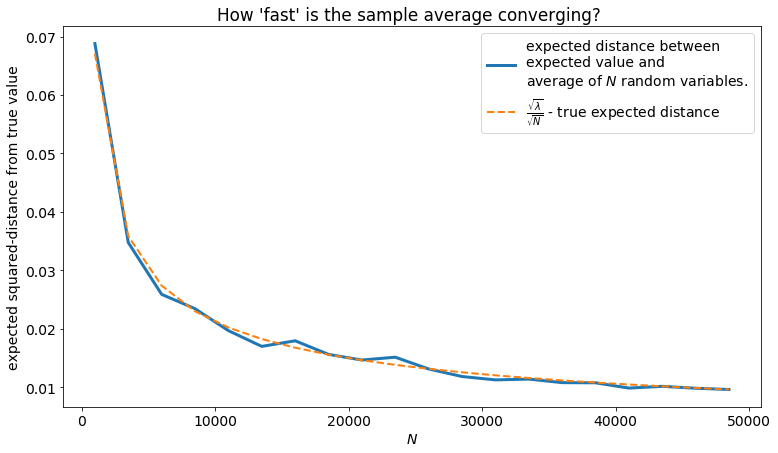

In [5]:
N_Y = 250 #use this many to approximate D(N)
N_array = np.arange( 1000, 50000, 2500 ) #use this many samples in the approx. to the variance.
D_N_results = np.zeros( len( N_array ) )

def D_N( n ):
    """
    This function approx. D_n, the average variance of using n samples.
    """
    Z = np.random.poisson( lambda_, (n, N_Y) )
    average_Z = Z.mean(axis=0)
    return np.sqrt( ((average_Z - expected_value)**2).mean() )

for i,n in enumerate(N_array):
    D_N_results[i] =  D_N(n)
    
    
plt.rcParams.update({'font.size': 14})
figsize( 12.5, 7)

plt.xlabel( "$N$" )
plt.ylabel( "expected squared-distance from true value" )
plt.plot(N_array, D_N_results, lw = 3, 
            label="expected distance between\n\
expected value and \naverage of $N$ random variables.")
plt.plot( N_array, np.sqrt(expected_value)/np.sqrt(N_array), lw = 2, ls = "--", 
        label = r"$\frac{\sqrt{\lambda}}{\sqrt{N}}$ - true expected distance" )
plt.legend()
plt.title( "How 'fast' is the sample average converging? " );

# The Disorder of Small Numbers

Knowing when the Law of Large Numbers does not hold is helpful for grounding our uncertainty. This is especially true when our sample size is not high enough. We can already see from the first plot above that emperical expected value is highly variant and does not converge to the true expected value unless the sample size is sufficiently large.

We'll see in the example below how we are more likely to observe extreme values in the average when the sample size is small.

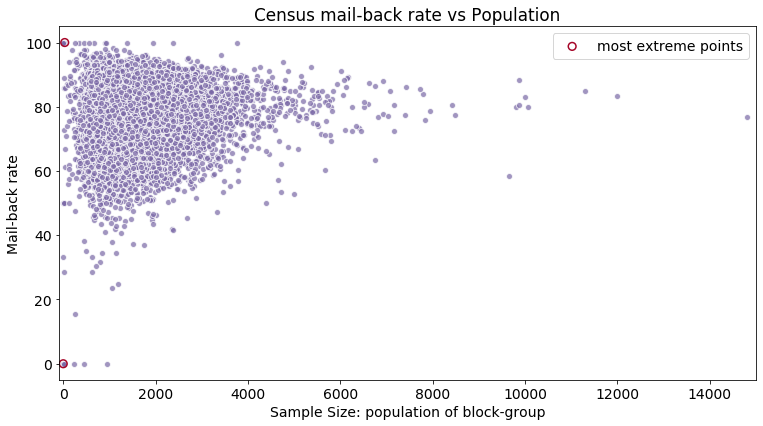

In [6]:
filepath = "census_data.csv"

if IN_COLAB:
    print('Fetching data from Github ...')
    url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter4_TheGreatestTheoremNeverTold/data/census_data.csv'
    _data = wget.download(url, )
else:
    filepath = os.path.join("data", filepath)
    
census_data = np.genfromtxt(filepath, 
                            skip_header=1, 
                            delimiter= ",")



figsize( 12.5, 6.5 )

plt.scatter(census_data[:,1], 
            census_data[:,0],
            color="#7A68A6",
            edgecolors='white', 
            alpha = 0.7)

# extreme points
i_min = np.argmin(census_data[:,0] )
i_max = np.argmax(census_data[:,0] )
plt.scatter([ census_data[i_min,1], census_data[i_max,1] ], 
            [ census_data[i_min,0],  census_data[i_max,0] ],
            label="most extreme points",
            s = 60, 
            marker = "o", 
            facecolors = "none",
            edgecolors = "#A60628", 
            linewidths = 1.5)

plt.legend(scatterpoints = 1)
plt.title("Census mail-back rate vs Population")
plt.ylabel("Mail-back rate")
plt.xlabel("Sample Size: population of block-group")
plt.xlim(-100, 15e3 )
plt.ylim( -5, 105);

We can see that the shape of the scatter plot tightens as the sample size increases. Also note that the most extreme means occur in the regions which have the lowest sample counts.

Let's look at a common example of the law of large numbers at play

# Reddit Upvotes

Consider ratings. We know that if only a few people have rated something highly, there is no good reason to believe that the high rating is a true reflection of quality. If on the otherhand, something has a high rating from a large number of sources, then we can trust that rating to be true.

However sorting ratings can be tricky. If we simply sort by the raw rating, we may be favouring items which have only a few high ratings over items which may have a lower raw rating, but from a larger number of people - the latter may be more relevant as it's rating is a truer reflection.

We'll use the example of Reddit upvotes to see how we can determine which submissions are the best by more than just the rating. 

We want to calculate the *true upvote ratio*, which we can think of as the *probability that a random persons gives a post an upvote instead of a downvote*. We can place a prior on the true upvote ratio and use the observed upvote ratio in th e likelihood to estimate a posterior of the true upvote ratio.

We'll choose a simple Uniform prior to avoid any biases associated with using historical upvote ratios as the prior.

### r/showerthoughts

We'll get the top posts frrom "r/showerthoughts" using the provided Python script. In this subreddit the title of the post is the post itself.

In [7]:
#adding a number to the end of the %run call will get the ith top post.
%run utils/top_showerthoughts_submissions.py 2

print("Post contents: \n")
print(top_post)

Post contents: 

Plumbers and Mechanics always seem to be portrayed as salt of the Earth, uneducated morons, but have knowledge and skills that the grand majority of us do not


<Figure size 900x468 with 0 Axes>

In [8]:
"""
contents: an array of the text from the last 100 top submissions to a subreddit
votes: a 2d numpy array of upvotes, downvotes for each submission.
"""
n_submissions = len(votes)
submissions = np.random.randint( n_submissions, size=4)
print("Some Submissions (out of %d total) \n-----------"%n_submissions)
for i in submissions:
    print('"' + contents[i] + '"')
    print("upvotes/downvotes: ",votes[i,:], "\n")

Some Submissions (out of 5 total) 
-----------
"Ending procrastination by exercising is both wait-loss and weight-loss."
upvotes/downvotes:  [34  4] 

"You have memories that you’ve never remembered before."
upvotes/downvotes:  [27  5] 

"You have memories that you’ve never remembered before."
upvotes/downvotes:  [27  5] 

"You have memories that you’ve never remembered before."
upvotes/downvotes:  [27  5] 



# PyMC3 Model

For a given true upvote ratio $p$ and $N$ votes in total, the number of upvotes will look like a Binomial random variable with parameters $p, N$ - which we can interpret exactly as the *probability of an upvote* (success) out of $N$ *trials*.

Let's create a function which computes the a posterior upvote ratio for different submissions:

In [9]:
def posterior_upvote_ratio(upvotes, downvotes, samples = 20000):
    """
    This function accepts the number of upvotes and downvotes a particular submission recieved, 
    and the number of posterior samples to return to the user. Assumes a uniform prior.
    """
    N = upvotes + downvotes
    with pm.Model() as model:
        upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
        observations = pm.Binomial( "obs",  N, upvote_ratio, observed=upvotes)
        
        trace = pm.sample(samples, step=pm.Metropolis())
    
    burned_trace = trace[int(samples / 4):]
    return burned_trace["upvote_ratio"]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [upvote_ratio]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:06<00:00, 11774.80draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/josinai/anaconda3/envs/axiom/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/home/josinai/anaconda3/envs/axiom/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [upvote_ratio]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:06<00:00, 11912.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/josinai/anaconda3/

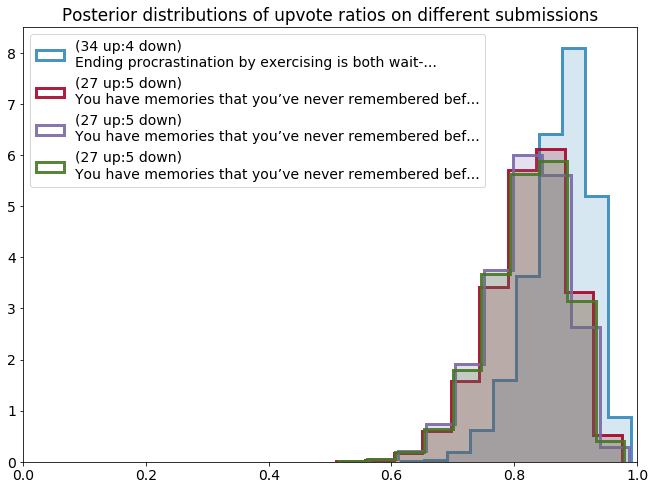

In [10]:
figsize( 11., 8)
posteriors = []
colours = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#CF4457"]
for i in range(len(submissions)):
    j = submissions[i]
    posteriors.append( posterior_upvote_ratio( votes[j, 0], votes[j,1] ) )
    plt.hist( posteriors[i], bins = 10, normed = True, alpha = .9, 
            histtype="step",color = colours[i%5], lw = 3,
            label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j,1], contents[j][:50]) )
    plt.hist( posteriors[i], bins = 10, normed = True, alpha = .2, 
            histtype="stepfilled",color = colours[i], lw = 3, )
    
plt.legend(loc="upper left")
plt.xlim( 0, 1)
plt.title("Posterior distributions of upvote ratios on different submissions");

### Sorting by Posterior

We can now sort the submissions based on the posterior of the true upvote ratio. Now how do we *sort a distribution*? One way is to use the mean, but this does not take into account the uncertainty of the posterior. 

What we can do instead is use the *95% least plausible value* which is defined as the valye such that there is only a 5% chance that the true parameter is lower - think of it as the lower bound of the 95% credible region.

